Some experiments with using [marisa-trie](https://github.com/kmike/marisa-trie) to collapse biological sequences. 

In [1]:
import skbio
import marisa_trie
from collections import defaultdict
import numpy as np
import pandas as pd
import random
%matplotlib inline

sids = {}
seq_d = defaultdict(list)

def unpacker(seq):
    sid = seq.metadata['id'].split('_', maxsplit=1)[0]
    if not sid in sids:
        sids[sid] = len(sids)
    # all of this is unnecessary, just compiling information in the "usual" ways to 
    # make sure that I have what I think I have in the trie
    seq_d[(str(seq))].append(sid)
    return str(seq)

sample_md = df = pd.read_csv('tiny-test/map', sep='\t', index_col=0)
seq_gen = skbio.io.read('tiny-test/seqs', format='fasta',)
trie = marisa_trie.Trie(map(unpacker, seq_gen))

In [2]:
def exact(trie, seq):
    return [(trie[str(seq)], 1.)]

def split_count(trie, seq):
    oids = trie.items(str(seq))
    oid_count = 1./len(oids)
    return [(oid[1], oid_count) for oid in oids]

def random_oid(trie, seq):
    oids = trie.items(str(seq))
    return [(random.choice(oids)[1], 1.)]

def last_oid(trie, seq):
    oids = trie.items(str(seq))
    return [(oids[-1][1], 1.)]

def all_count(trie, seq):
    oids = trie.items(str(seq))
    return [(oid[1], 1.) for oid in oids]
        
def table_summary(df):
    print("Samples: ", len(df.index))
    print("Observations: ", len(df.columns))
    print("Sequence/sample counts: ")
    print(df.T.sum())

def table_from_trie(trie, sids, seq_iter, cluster_f=exact):
    """
    """
    data = np.zeros((len(sids), len(trie)+25))
    result = pd.DataFrame(data, columns=range(len(trie)+25), index=sids)

    for seq in seq_iter:
        sid = seq.metadata['id'].split('_', maxsplit=1)[0]
        for oid, count in cluster_f(trie, seq):
            result[oid][sid] += count
    # this requires two passes, there must be a better way to drop columns with zero count in place
    result.drop([i for i,e in enumerate(result.sum()) if e == 0], axis=1, inplace=True)
    return result

In [3]:
seq_iter = skbio.io.read('tiny-test/seqs', format='fasta')
table_summary(table_from_trie(trie, sids, seq_iter, exact))

Samples:  9
Observations:  43
Sequence/sample counts: 
f1          22
f2          22
f3          22
t1          23
f4          22
p2          22
t2          22
not16S.1    22
p1          23
dtype: float64


In [4]:
seq_iter = skbio.io.read('tiny-test/seqs', format='fasta', )
table_summary(table_from_trie(trie, sids, seq_iter, split_count))

Samples:  9
Observations:  43
Sequence/sample counts: 
f1          22
f2          22
f3          22
t1          23
f4          22
p2          22
t2          22
not16S.1    22
p1          23
dtype: float64


In [5]:
seq_iter = skbio.io.read('tiny-test/seqs', format='fasta', )
table_summary(table_from_trie(trie, sids, seq_iter, random_oid))

Samples:  9
Observations:  38
Sequence/sample counts: 
f1          22
f2          22
f3          22
t1          23
f4          22
p2          22
t2          22
not16S.1    22
p1          23
dtype: float64


In [6]:
seq_iter = skbio.io.read('tiny-test/seqs', format='fasta', )
table_summary(table_from_trie(trie, sids, seq_iter, all_count))

Samples:  9
Observations:  43
Sequence/sample counts: 
f1           87
f2           93
f3           87
t1          124
f4          110
p2           51
t2           80
not16S.1     22
p1           24
dtype: float64


In [7]:
seq_iter = skbio.io.read('tiny-test/seqs', format='fasta', )
table_summary(table_from_trie(trie, sids, seq_iter, last_oid))

Samples:  9
Observations:  23
Sequence/sample counts: 
f1          22
f2          22
f3          22
t1          23
f4          22
p2          22
t2          22
not16S.1    22
p1          23
dtype: float64


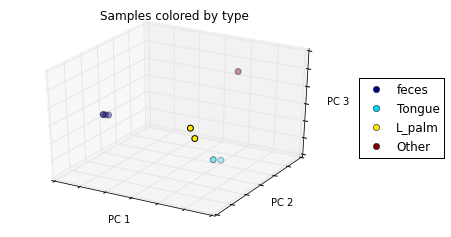

In [11]:
from skbio.diversity.beta import pw_distances
from skbio.stats.ordination import PCoA

seq_iter = skbio.io.read('tiny-test/seqs', format='fasta', )
otu_table = table_from_trie(trie, sids, seq_iter, exact)

dm = pw_distances(otu_table, otu_table.index)
dm
pcoa_results = PCoA(dm).scores()
_ = pcoa_results.plot(df=df,
                        column='SampleType',
                        axis_labels=['PC 1', 'PC 2', 'PC 3'],
                        title='Samples colored by type',
                        s=35)
